In [441]:
import pandas as pd
from apriori import Apriori
import statistics
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
from functools import reduce

In [2]:
original_store_data = pd.read_csv("../Dataset/SampleSuperstore.csv")

In [3]:
print(original_store_data.shape)
original_store_data.head()

(9994, 13)


,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [4]:
print(original_store_data['Ship Mode'].unique())
print(original_store_data['Segment'].unique())
print(original_store_data['Country'].unique())
print(original_store_data['Category'].unique())
print(original_store_data['Sub-Category'].unique())

['Second Class' 'Standard Class' 'First Class' 'Same Day']
['Consumer' 'Corporate' 'Home Office']
['United States']
['Furniture' 'Office Supplies' 'Technology']
['Bookcases' 'Chairs' 'Labels' 'Tables' 'Storage' 'Furnishings' 'Art'
 'Phones' 'Binders' 'Appliances' 'Paper' 'Accessories' 'Envelopes'
 'Fasteners' 'Supplies' 'Machines' 'Copiers']


In [5]:
algorithm = Apriori()
try:
    algorithm.valid_input_check(original_store_data)
except:
    print("The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class")

The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class


#### Changing to a suitable dataframe

In [6]:
store_data = original_store_data[['Postal Code', 'Sub-Category', 'Quantity']]
store_data = store_data.groupby(['Postal Code', 'Sub-Category']).sum()
# Convert quantities to 0/1
store_data['Quantity'] =  (store_data['Quantity']>0).astype(int)
# pivot table and convert it to sparse data
pivoted_store_data = store_data.pivot_table(index='Postal Code', columns='Sub-Category', values='Quantity', fill_value=0)
sparse_store_data = pivoted_store_data.astype(pd.SparseDtype(int, fill_value=0))

In [7]:
print(sparse_store_data.shape)
sparse_store_data.head()

(631, 17)


Sub-Category,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
Postal Code,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0
1752,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1810,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
1841,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1


In [8]:
try:
    algorithm.valid_input_check(sparse_store_data)
except:
    print("The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class")

## Apriori Algorithm and extract frequent items as features 

In [9]:
# check for the mean occurence for each combination 
item_count = algorithm.apriori(df=sparse_store_data, use_colnames=True, verbose=1, count=True, min_support=0.001)

Processing 30940 combinations | Sampling itemset size 5

Processing 17 combinations | Sampling itemset size 176531


In [10]:
# 2^^17 
print(f"Total number of combinations of all itemsets: {len(item_count)}")
average_occurence = round(sum(item_count['count'])/len(item_count), 2)
median_occurence = statistics.median(item_count['count'])
percentile_99 = np.percentile(item_count['count'], 99.9)
print(f"Average Occurence of each combination: {average_occurence}")
print(f"Median Occurence of each combination: {median_occurence}")
print(f"99.992 Percentile Occurence of each combination: {percentile_99}")

Total number of combinations of all itemsets: 131071
Average Occurence of each combination: 26.62
Median Occurence of each combination: 23.0
99.992 Percentile Occurence of each combination: 128.0


In [11]:
# We define frequent item as those that occur more than the average occurence
frequent_items = list(item_count[item_count['count']>percentile_99]['itemsets'])
len(frequent_items)

131

In [12]:
new_col = frequent_items

### Data Preprocessing for Clustering Users

In [13]:
new_df = pd.DataFrame(index=sparse_store_data.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data.index:
        for item in itemset:
            if sparse_store_data.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

  0%|          | 0/131 [00:00<?, ?it/s]

100%|██████████| 131/131 [00:54<00:00,  2.40it/s]


In [14]:
# Adding Label to the new table with frequent items as features
final_df = new_df.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
"""
Combining label if multiple labels are found for the same Postal Code
eg: Postal 123 contains different transactions(rows) with different 'Segment' --> consumer and corporate, 
    it will be combined to one row with 'Segment' --> consumer, corporate
"""
final_df = final_df.groupby('Postal Code').agg({
    **{col: 'max' for col in final_df.columns if col not in ['Postal Code', 'Segment']},
    'Segment': lambda x: ', '.join(sorted(set(x)))
}).reset_index()
final_df.rename(columns={"Segment": "Label"}, inplace=True)

In [15]:
# Label Transform the Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['Label'] = le.fit_transform(final_df['Label'])

In [16]:
print(f"Number of unique Labels: {len(final_df['Label'].unique())}")

Number of unique Labels: 7


In [17]:
# final_df.to_csv("../Result/SuperStoreFrequentFeatures1.csv")
print(final_df.shape)
final_df.head()

(631, 133)


,Postal Code,(Accessories),(Appliances),(Art),(Binders),(Bookcases),(Chairs),(Envelopes),(Fasteners),(Furnishings),...,"(Storage, Binders, Art, Paper)","(Storage, Phones, Binders, Art)","(Phones, Furnishings, Art, Paper)","(Chairs, Binders, Furnishings, Paper)","(Phones, Binders, Furnishings, Paper)","(Storage, Binders, Furnishings, Paper)","(Storage, Phones, Binders, Furnishings)","(Storage, Phones, Binders, Paper)","(Phones, Storage, Furnishings, Paper)",Label
0,1040,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,1453,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1752,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1810,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1841,0,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,2


### Data Preprocessing for Clustering Items

In [18]:
new_df = pd.DataFrame(index=sparse_store_data.columns)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for item in sparse_store_data.columns:
        if item not in itemset:
            new_df.at[item, itemset] = 0


100%|██████████| 131/131 [00:00<00:00, 1641.67it/s]


In [19]:
final_df2 = new_df.merge(original_store_data[['Sub-Category', 'Category']], how='left', on='Sub-Category').set_index('Sub-Category').drop_duplicates(keep='first')
final_df2.rename(columns={"Category": "Label"}, inplace=True)

le = LabelEncoder()
final_df2['Label'] = le.fit_transform(final_df2['Label'])

In [20]:
print(f"Number of unique Labels: {len(final_df2['Label'].unique())}")

Number of unique Labels: 3


In [21]:
# final_df2.to_csv("../Result/SuperStoreFrequentFeatures2.csv")
print(final_df2.shape)
final_df2.head()

(16, 132)


,(Accessories),(Appliances),(Art),(Binders),(Bookcases),(Chairs),(Envelopes),(Fasteners),(Furnishings),(Labels),...,"(Storage, Binders, Art, Paper)","(Storage, Phones, Binders, Art)","(Phones, Furnishings, Art, Paper)","(Chairs, Binders, Furnishings, Paper)","(Phones, Binders, Furnishings, Paper)","(Storage, Binders, Furnishings, Paper)","(Storage, Phones, Binders, Furnishings)","(Storage, Phones, Binders, Paper)","(Phones, Storage, Furnishings, Paper)",Label
Sub-Category,,,,,,,,,,,,,,,,,,,,,
Accessories,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Appliances,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Art,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
Binders,0,0,0,1,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,1
Bookcases,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering Different Users (based on postal code)

### DBSCAN

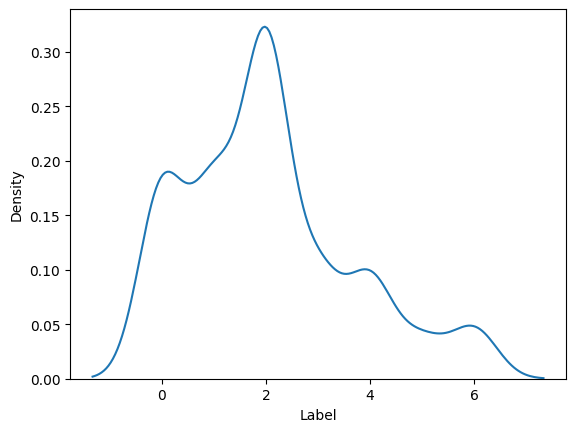

In [193]:
sb.kdeplot(final_df['Label'])
plt.show()

the lowest density of a group is roughly 0.045, which translates to 631*0.045 = 28 points a group

In [254]:
X = final_df.iloc[:, :-1]
X= X.rename(str,axis="columns") 

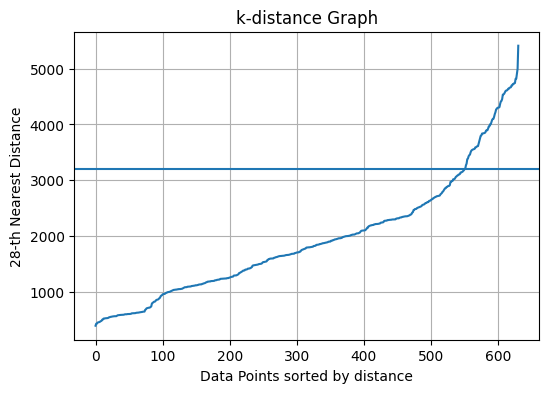

In [255]:
from sklearn.neighbors import NearestNeighbors

minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(3200)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 3200

In [260]:
from sklearn.cluster import DBSCAN

min_samples_ = [20, 25, 30, 35, 40, 45, 50, 55, 60]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=3200, min_samples=i).fit(X)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 4
For min_samples: 30 Number of Clusters Predicted: 5
For min_samples: 35 Number of Clusters Predicted: 6
For min_samples: 40 Number of Clusters Predicted: 7
For min_samples: 45 Number of Clusters Predicted: 6
For min_samples: 50 Number of Clusters Predicted: 6
For min_samples: 55 Number of Clusters Predicted: 5
For min_samples: 60 Number of Clusters Predicted: 6


In [261]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X, cluster.labels_))
    db_.append(davies_bouldin_score(X, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

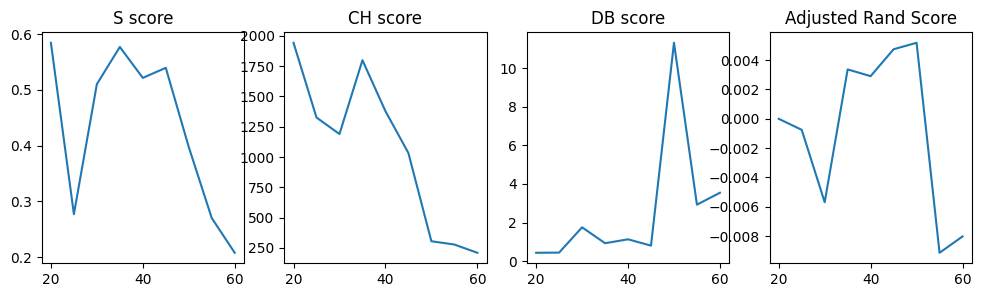

In [262]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

eps = 3200  and min_samples = 45 provides the second highest adjusted rand score, relatively high S score and relatively low DB score. 

In [263]:
final_dbscan = DBSCAN(eps=3200, min_samples=45).fit(X)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.5394624574567182
Calinski Harabasz Score: 1032.4551933508928
Davies Bouldin Score: 0.8074351174093229
Adjusted Rand Index: 0.004734365656700725


In [264]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  6


### KMeans

In [189]:
from sklearn.cluster import KMeans

n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X)
    kmeans_.append(kmeans)

In [190]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X, cluster.labels_))
    db_.append(davies_bouldin_score(X, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

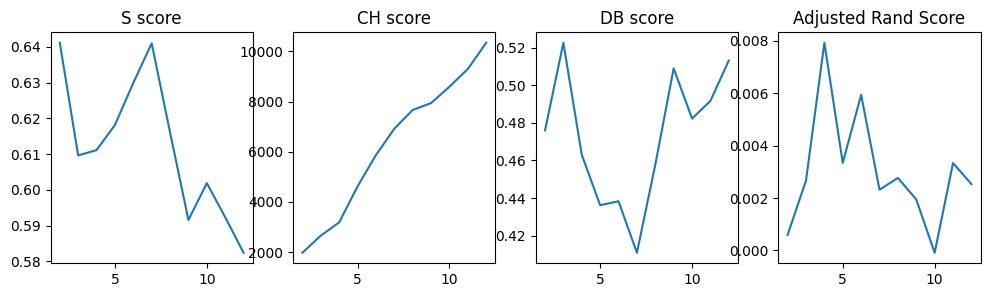

In [191]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 4 provides the highest Adjusted Rand Score, relatively high S Score and relatively low DB Score. 

In [192]:
final_kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.6111147856317314
Calinski Harabasz Score: 3182.492260839047
Davies Bouldin Score: 0.4630063806434899
Adjusted Rand Index: 0.007922750053569605


K Means provide a higher Adjusted Rand Index than DBSCAN which suggests that the 4 clusters formed by it are of slighlty closer similarity to the actual Labels than the 6 clusters formed by DBSCAN

## Clustering Different Users (based on postal code) with PCA

In [265]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pc = pd.DataFrame(pca.transform(X))

0.9999999871934689


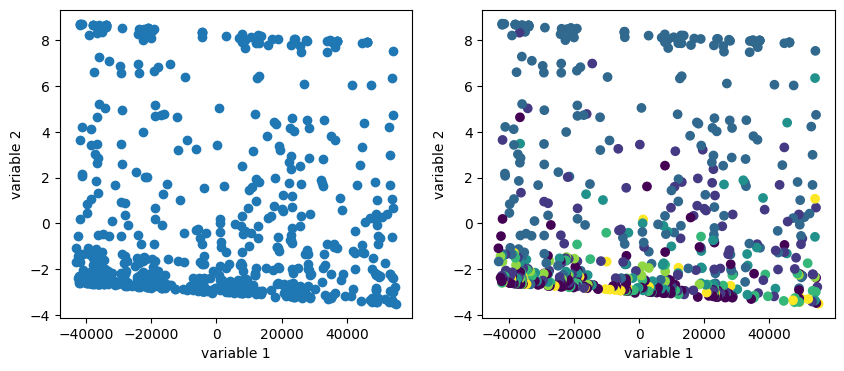

In [266]:
# PCA does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

### DBSCAN

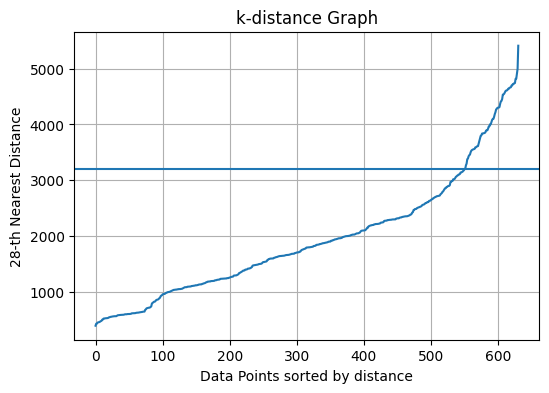

In [268]:
minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X_pc)
distances, indices = neigh.kneighbors(X_pc)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(3200)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 3200

In [270]:
from sklearn.cluster import DBSCAN

min_samples_ = [20, 25, 30, 35, 40, 45, 50, 55, 60]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=3200, min_samples=i).fit(X_pc)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 4
For min_samples: 30 Number of Clusters Predicted: 5
For min_samples: 35 Number of Clusters Predicted: 6
For min_samples: 40 Number of Clusters Predicted: 7
For min_samples: 45 Number of Clusters Predicted: 6
For min_samples: 50 Number of Clusters Predicted: 6
For min_samples: 55 Number of Clusters Predicted: 5
For min_samples: 60 Number of Clusters Predicted: 6


In [271]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X_pc, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_pc, cluster.labels_))
    db_.append(davies_bouldin_score(X_pc, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

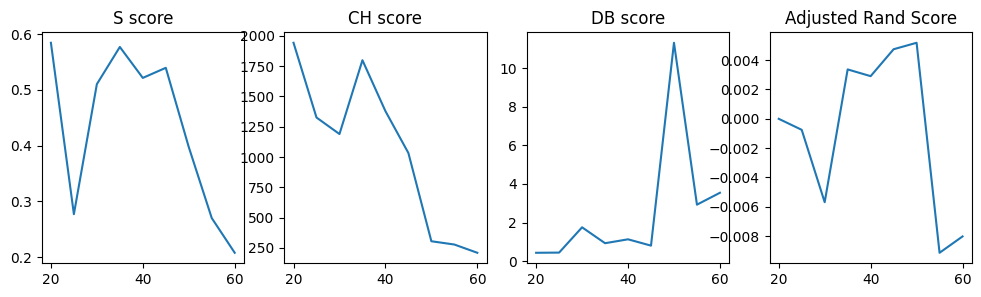

In [272]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

eps = 3200  and min_samples = 45 provides the second highest adjusted rand score, relatively high S score and relatively low DB score. 

In [273]:
final_dbscan = DBSCAN(eps=3200, min_samples=45).fit(X)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.5394624574567182
Calinski Harabasz Score: 1032.4551933508928
Davies Bouldin Score: 0.8074351174093229
Adjusted Rand Index: 0.004734365656700725


In [274]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  6


### KMeans

In [81]:
n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X_pc)
    kmeans_.append(kmeans)

In [217]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X_pc, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_pc, cluster.labels_))
    db_.append(davies_bouldin_score(X_pc, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

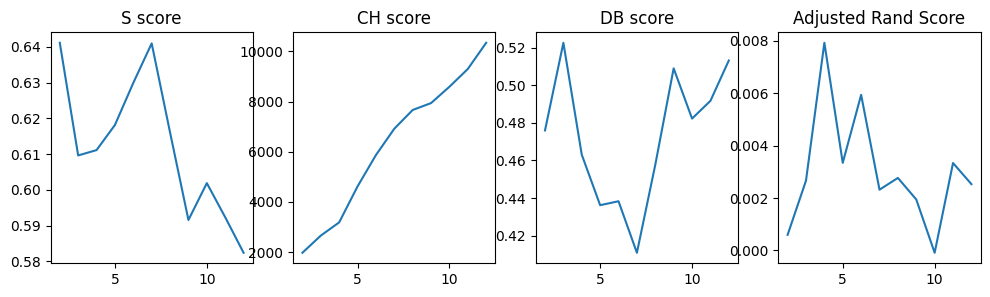

In [218]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 4 provides the highest Adjusted Rand Score, relatively high S Score and relatively low DB Score. 

In [219]:
final_kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.6111147856317314
Calinski Harabasz Score: 3182.492260839047
Davies Bouldin Score: 0.4630063806434899
Adjusted Rand Index: 0.007922750053569605


K Means provide a higher Adjusted Rand Index than DBSCAN which suggests that the 4 clusters formed by it are of slighlty closer similarity to the actual Labels than the 6 clusters formed by DBSCAN

Clustering with and without PCA provides the same results and this is expected given that the 2 PCs we used explain 0.99999999 of the variance, ALMOST 1!!!

## Clustering Different Users (based on postal code) with t-SNE

In [294]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=70).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(631, 2)

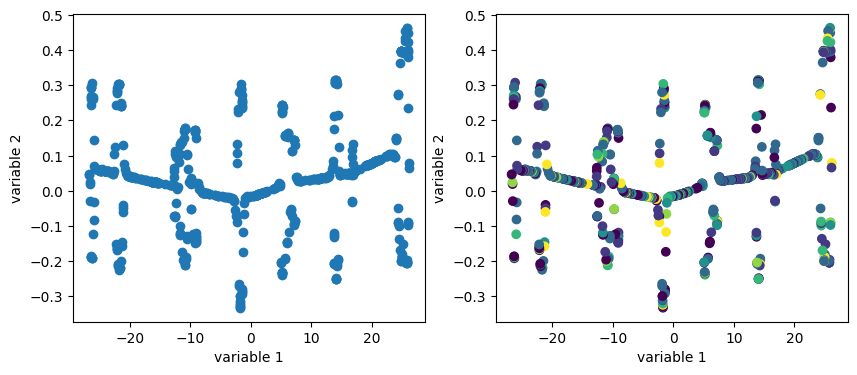

In [295]:
# t-SNE does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

### DBSCAN

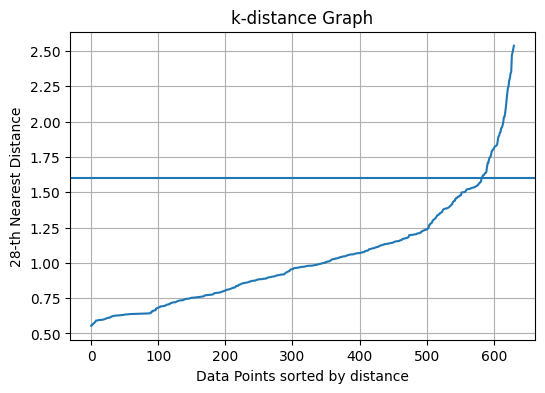

In [297]:
minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X_embedded)
distances, indices = neigh.kneighbors(X_embedded)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(1.6)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 1.6

In [309]:
min_samples_ = [20, 25, 30, 35, 40, 45, 50, 55, 60]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=1.6, min_samples=i).fit(X_embedded)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 5
For min_samples: 30 Number of Clusters Predicted: 7
For min_samples: 35 Number of Clusters Predicted: 8
For min_samples: 40 Number of Clusters Predicted: 7
For min_samples: 45 Number of Clusters Predicted: 7
For min_samples: 50 Number of Clusters Predicted: 8
For min_samples: 55 Number of Clusters Predicted: 7
For min_samples: 60 Number of Clusters Predicted: 2


In [310]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X_embedded, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_embedded, cluster.labels_))
    db_.append(davies_bouldin_score(X_embedded, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

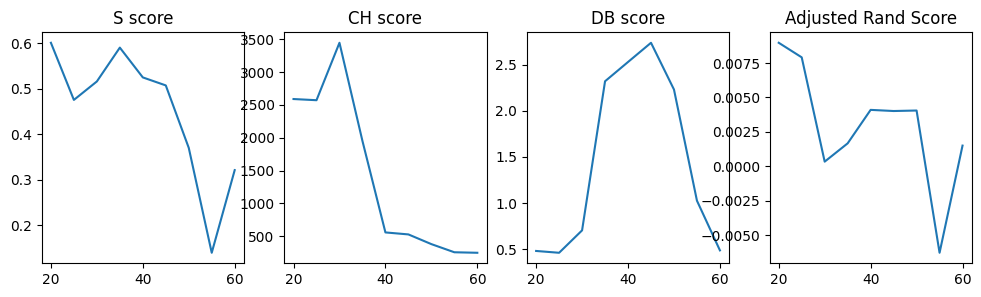

In [311]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

epsilon = 1.6 and min_samples = 20 has the highes adjuste rand score with highes s score, relatively high ch score and relatively low db score

In [313]:
final_dbscan = DBSCAN(eps=1.6, min_samples=20).fit(X_embedded)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.6007702946662903
Calinski Harabasz Score: 2588.726648313839
Davies Bouldin Score: 0.48209792634950616
Adjusted Rand Index: 0.008968013764245723


In [314]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  3


### KMeans

In [315]:
n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X_embedded)
    kmeans_.append(kmeans)

In [316]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X_embedded, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X_embedded, cluster.labels_))
    db_.append(davies_bouldin_score(X_embedded, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

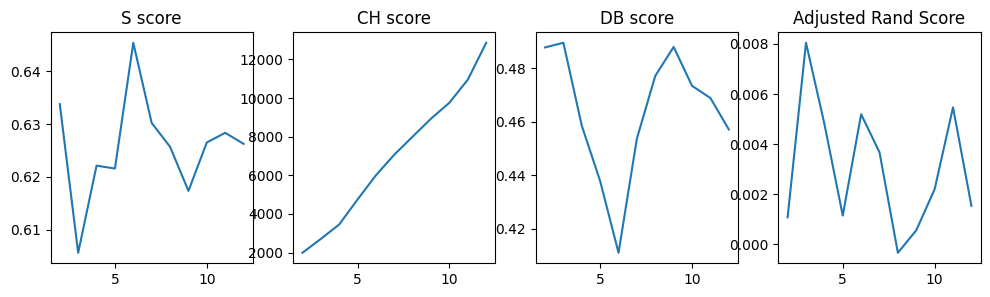

In [317]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 4 provides highest Adjusted Rand Score, relatively high S Score and relatively low DB Score. 

In [321]:
final_kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.5650269389152527
Calinski Harabasz Score: 2374.174060065427
Davies Bouldin Score: 0.4741569571768327
Adjusted Rand Index: 0.007922750053569605


DBSCAN provide a slighly higher Adjusted Rand Index than KMeans which suggests that the 3 clusters formed by it are of slighlty closer similarity to the actual Labels than the 4 clusters formed by KMeans

Do note that all the adjusted rand index obtained are all lower than 0.01, which maybe caused by the wrong features extracted. 

## Improvement: extract frequent items as features per label

In [409]:
sparse_store_data_label = sparse_store_data.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
sparse_store_data_label.head()

,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables,Segment
Postal Code,,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Home Office
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,Corporate
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,Corporate
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,Corporate
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,Corporate


In [410]:
labelling = sparse_store_data_label.groupby('Postal Code')[['Segment']].agg(lambda x: ', '.join(sorted(set(x))))

le = LabelEncoder()
labelling['Label'] = le.fit_transform(labelling['Segment'])
print(len(labelling['Label'].unique()))

7


In [411]:
sparse_store_data_label = sparse_store_data_label.merge(labelling[['Label']], on='Postal Code').drop(['Segment'], axis=1)
sparse_store_data_label = sparse_store_data_label[~sparse_store_data_label.index.duplicated(keep='first')]
sparse_store_data_label.head()

,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables,Label
Postal Code,,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1
1752,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1810,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0
1841,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,2


In [412]:
sparse_store_data_label.shape

(631, 18)

In [458]:
unique_labels = sorted(sparse_store_data_label['Label'].unique())

new_col = []
# changing the min_support just so that each label at least has some number of frequent itemset , can ommit this too
# adjust from 0.5
for i in unique_labels:
    if i == 1:
        min_support = 0.2
    elif i == 2:
        min_support = 0.55
    elif i == 3:
        min_support = 0.2
    else:
        min_support=0.1
    item_count = algorithm.apriori(df=sparse_store_data_label[sparse_store_data_label['Label']==i].drop('Label', axis=1), use_colnames=True, verbose=1, count=False, min_support=min_support)['itemsets'].unique().tolist()
    print(f"Label {i} has {len(item_count)} frequent items given a minimum support of {min_support}")
    new_col=new_col+item_count
print("Total number of frequent items: ", len(new_col))
new_col = list(set(new_col))
print("Total number of unique frequent items: ", len(new_col))

Processing 3 combinations | Sampling itemset size 32
Label 0 has 11 frequent items given a minimum support of 0.1
Processing 76 combinations | Sampling itemset size 43
Label 1 has 48 frequent items given a minimum support of 0.2
Processing 20 combinations | Sampling itemset size 54
Label 2 has 81 frequent items given a minimum support of 0.55
Processing 87 combinations | Sampling itemset size 3
Label 3 has 23 frequent items given a minimum support of 0.2
Processing 24 combinations | Sampling itemset size 3
Label 4 has 14 frequent items given a minimum support of 0.1
Processing 216 combinations | Sampling itemset size 3
Label 5 has 34 frequent items given a minimum support of 0.1
Processing 3 combinations | Sampling itemset size 32
Label 6 has 11 frequent items given a minimum support of 0.1
Total number of frequent items:  222
Total number of unique frequent items:  90


### Data Preprocessing for clustering users

In [459]:
new_df = pd.DataFrame(index=sparse_store_data_label.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data_label.index:
        for item in itemset:
            if sparse_store_data_label.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:55<00:00,  1.62it/s]


In [462]:
final_df = new_df.merge(sparse_store_data_label[['Label']], how='left', on='Postal Code')
print(final_df.shape)
final_df.head()

(631, 91)


,(Envelopes),"(Storage, Binders)","(Phones, Binders)","(Bookcases, Paper)",(Chairs),(Furnishings),"(Storage, Binders, Art)","(Phones, Binders, Art, Paper)","(Phones, Furnishings, Paper)","(Binders, Art, Paper)",...,"(Phones, Binders, Furnishings)","(Storage, Phones, Binders)",(Appliances),"(Phones, Storage, Art)","(Binders, Furnishings, Paper)","(Binders, Appliances)","(Binders, Art)","(Phones, Storage, Accessories)","(Chairs, Paper)",Label
Postal Code,,,,,,,,,,,,,,,,,,,,,
1040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1453,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1752,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1810,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1841,0,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,2


### Clustering Different Users (based on postal code)

#### DBSCAN

In [464]:
X = final_df.iloc[:, :-1]
X= X.rename(str,axis="columns") 

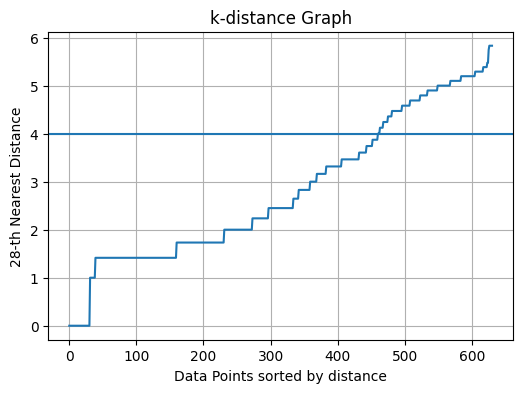

In [467]:
from sklearn.neighbors import NearestNeighbors

minPts = 28
neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
sorted_distances = np.sort(distances[:, minPts-1], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Distance')
plt.axhline(4)
plt.grid(True)
plt.show()

From the Elbow Plot, we determine epsilon to be 4

In [477]:
from sklearn.cluster import DBSCAN

min_samples_ = [5, 10, 15, 20, 25, 30, 35, 40]
dbscan_ = []

for i in min_samples_:
    dbscan = DBSCAN(eps=4, min_samples=i).fit(X)
    dbscan_results = dbscan.labels_
    dbscan_.append(dbscan)
    print(f"For min_samples: {i} Number of Clusters Predicted: {len(np.unique(dbscan_results))}")

For min_samples: 5 Number of Clusters Predicted: 4
For min_samples: 10 Number of Clusters Predicted: 5
For min_samples: 15 Number of Clusters Predicted: 3
For min_samples: 20 Number of Clusters Predicted: 3
For min_samples: 25 Number of Clusters Predicted: 3
For min_samples: 30 Number of Clusters Predicted: 3
For min_samples: 35 Number of Clusters Predicted: 3
For min_samples: 40 Number of Clusters Predicted: 3


In [478]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in dbscan_:
    s_.append(silhouette_score(X, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X, cluster.labels_))
    db_.append(davies_bouldin_score(X, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

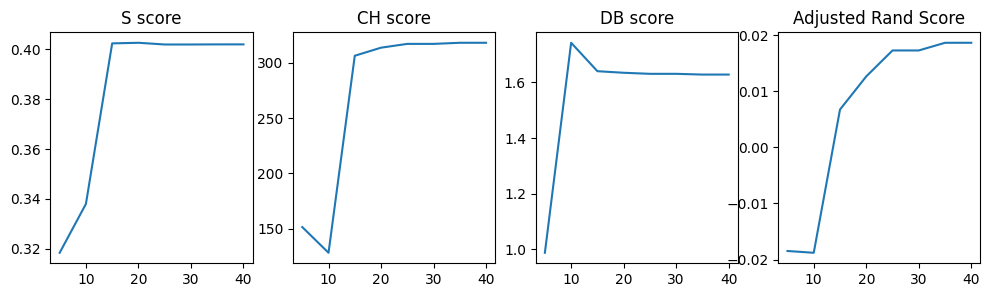

In [479]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(min_samples_, s_)
ax[0].set_title("S score")
ax[1].plot(min_samples_, ch_)
ax[1].set_title("CH score")
ax[2].plot(min_samples_, db_)
ax[2].set_title("DB score")
ax[3].plot(min_samples_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

eps = 4  and min_samples = 35 provides the highest adjusted rand score, relatively high S score and CH score. 

In [480]:
final_dbscan = DBSCAN(eps=4, min_samples=35).fit(X)
dbscan_results = final_dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: 0.40187893992624324
Calinski Harabasz Score: 318.1905200880398
Davies Bouldin Score: 1.628314288970442
Adjusted Rand Index: 0.01868812010026902


In [481]:
print("Number of clusters formed: ", len(np.unique(dbscan_results)))

Number of clusters formed:  3


#### KMeans

In [482]:
n_clusters_ = np.arange(2, 13)
kmeans_ = []

for i in n_clusters_:
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X)
    kmeans_.append(kmeans)

In [483]:
s_ = []
ch_ = []
db_ = []
rand_ = []

for cluster in kmeans_:
    s_.append(silhouette_score(X, cluster.labels_, metric='euclidean'))
    ch_.append(calinski_harabasz_score(X, cluster.labels_))
    db_.append(davies_bouldin_score(X, cluster.labels_))
    rand_.append(adjusted_rand_score(final_df['Label'] , cluster.labels_))

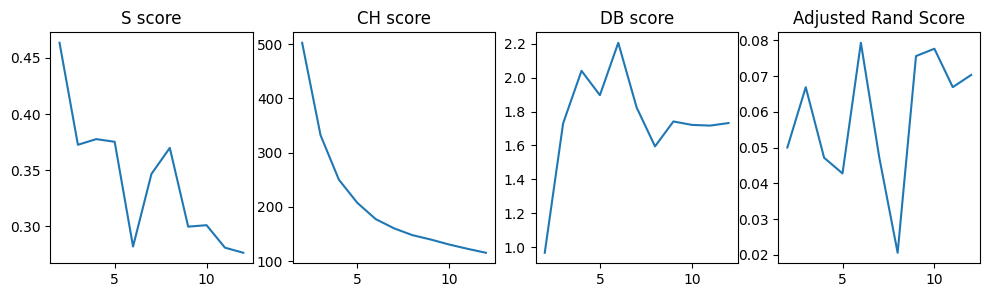

In [484]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(n_clusters_, s_)
ax[0].set_title("S score")
ax[1].plot(n_clusters_, ch_)
ax[1].set_title("CH score")
ax[2].plot(n_clusters_, db_)
ax[2].set_title("DB score")
ax[3].plot(n_clusters_, rand_)
ax[3].set_title("Adjusted Rand Score")
plt.show()

K = 6 provides the highest Adjusted Rand Score. 

In [485]:
final_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++').fit(X)
kmeans_results = final_kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.28204432487586956
Calinski Harabasz Score: 177.47459461920076
Davies Bouldin Score: 2.2063180650666987
Adjusted Rand Index: 0.07935017128095191


K Means provide a higher Adjusted Rand Index than DBSCAN which suggests that the 6 clusters formed by it are of closer similarity to the actual Labels than the 3 clusters formed by DBSCAN

## Clustering Different Items (based on sub-category)

### K Means Clustering (K=3)

In [29]:
print("Number of unique labels: ", len(final_df2['Label'].unique()))

Number of unique labels:  3


In [82]:
X = final_df2.iloc[:, :-1]
X= X.rename(str,axis="columns") 
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

In [83]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: 0.26749595376213653
Calinski Harabasz Score: 2.483190709046455
Davies Bouldin Score: 0.5381342332463062
Adjusted Rand Index: -0.12177121771217712


#### PCA

In [97]:
pca = PCA(n_components=6)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pc = pd.DataFrame(pca.transform(X))

0.7655946216877845


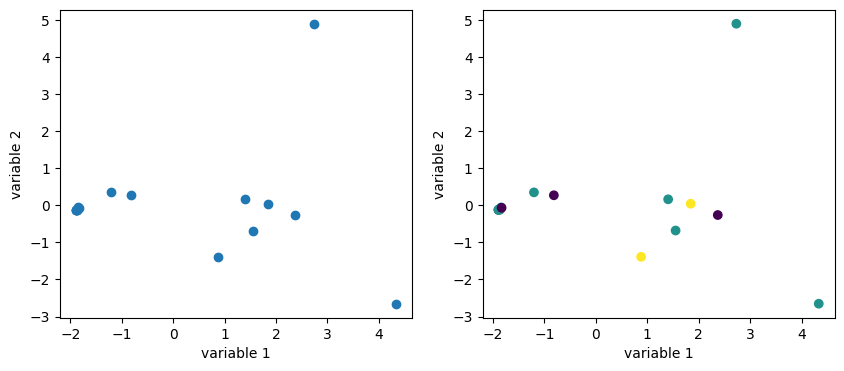

In [98]:
# PCA does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df2['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [99]:
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X_pc)
kmeans_results = kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_pc, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_pc, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_pc, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: 0.438032206002261
Calinski Harabasz Score: 4.743302065216877
Davies Bouldin Score: 1.102623936350596
Adjusted Rand Index: -0.0735930735930736


#### t-SNE

In [32]:
X_embedded = TSNE(n_components=2, init='pca', perplexity=5).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(16, 2)

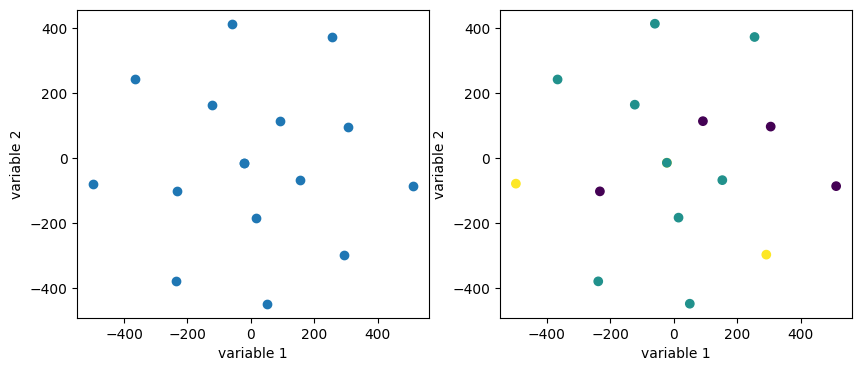

In [33]:
# t-SNE does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df2['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [34]:
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

In [35]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: -0.026974763793278983
Calinski Harabasz Score: 1.2480493462673974
Davies Bouldin Score: 2.881470939387807
Adjusted Rand Index: -0.10599078341013825


### Changing Frequent Features

#### User-based Clustering, Reducing Frequent Features

In [36]:
limit = np.percentile(item_count['count'], 99.99)

# We define frequent item as those that occur more than the average occurence
frequent_items = list(item_count[item_count['count']>limit]['itemsets'])
print(len(frequent_items))

new_col = frequent_items

14


In [37]:
new_df = pd.DataFrame(index=sparse_store_data.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data.index:
        for item in itemset:
            if sparse_store_data.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


In [38]:
# Adding Label to the new table with frequent items as features
final_df3 = new_df.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
"""
Combining label if multiple labels are found for the same Postal Code
eg: Postal 123 contains different transactions(rows) with different 'Segment' --> consumer and corporate, 
    it will be combined to one row with 'Segment' --> consumer, corporate
"""
final_df3 = final_df3.groupby('Postal Code').agg({
    **{col: 'max' for col in final_df3.columns if col not in ['Postal Code', 'Segment']},
    'Segment': lambda x: ', '.join(sorted(set(x)))
}).reset_index()
final_df3.rename(columns={"Segment": "Label"}, inplace=True)

In [39]:
# Label Transform the Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df3['Label'] = le.fit_transform(final_df3['Label'])

In [40]:
# final_df.to_csv("../Result/SuperStoreFrequentFeatures1.csv")
print(final_df3.shape)
final_df3.head()

(631, 16)


,Postal Code,(Accessories),(Art),(Binders),(Chairs),(Furnishings),(Paper),(Phones),(Storage),"(Binders, Art)","(Binders, Furnishings)","(Binders, Paper)","(Phones, Binders)","(Storage, Binders)","(Furnishings, Paper)",Label
0,1040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
1,1453,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1
2,1752,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1810,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0
4,1841,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2


## Clustering Different Users (based on postal code)

### K Means Clustering (K=7)

In [100]:
from sklearn.cluster import KMeans

X = final_df3.iloc[:, :-1]
X= X.rename(str,axis="columns") 
kmeans = KMeans(n_clusters=len(final_df3['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

In [101]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")

Silhouette Score: 0.6409682818589875
Calinski Harabasz Score: 6917.364025552514
Davies Bouldin Score: 0.41085009483908197
Adjusted Rand Index: 0.002315601522591607


#### PCA

In [104]:
pca = PCA(n_components=2)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pc = pd.DataFrame(pca.transform(X))

0.9999999978969755


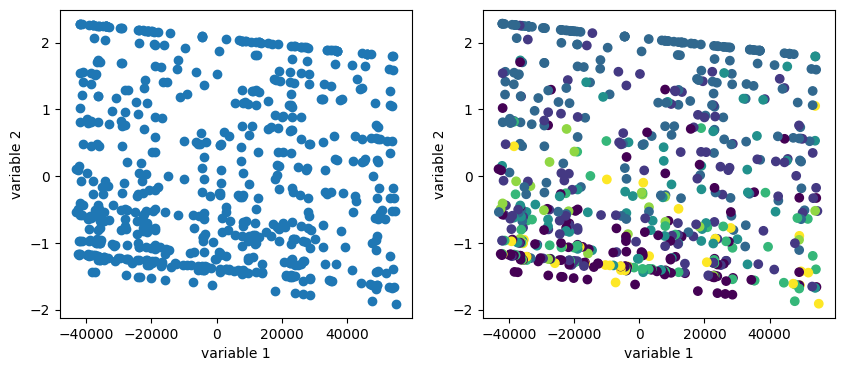

In [106]:
# PCA does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df3['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [107]:
kmeans = KMeans(n_clusters=len(final_df3['Label'].unique()), random_state=0, init='k-means++').fit(X_pc)
kmeans_results = kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_pc, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_pc, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_pc, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df3['Label'] , kmeans_results)}")

Silhouette Score: 0.6409686058257997
Calinski Harabasz Score: 6917.364998068704
Davies Bouldin Score: 0.41084986658643713
Adjusted Rand Index: 0.002315601522591607


#### t-SNE

In [43]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=90).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(631, 2)

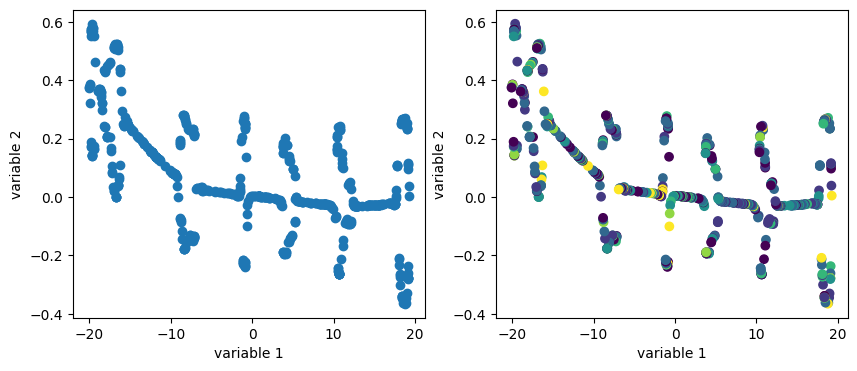

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [45]:
kmeans = KMeans(n_clusters=len(final_df['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

In [46]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df3['Label'] , kmeans_results)}")

Silhouette Score: 0.6025316620539456
Calinski Harabasz Score: 5050.605335371792
Davies Bouldin Score: 0.43778086362704544
Adjusted Rand Index: 0.004937028396643184


#### User-based Clustering, frequent itemset contains at least 2 items

In [47]:
limit = np.percentile(item_count['count'], 99.9)

# We define frequent item as those that occur more than the average occurence
frequent_items = list(item_count[item_count['count']>limit]['itemsets'])
print(len(frequent_items))

131


In [48]:
new_col = []
for i in range(len(frequent_items)):
    if(len(frequent_items[i])>1):
        new_col.append(frequent_items[i])

In [49]:
new_df = pd.DataFrame(index=sparse_store_data.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data.index:
        for item in itemset:
            if sparse_store_data.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

  0%|          | 0/117 [00:00<?, ?it/s]

100%|██████████| 117/117 [00:49<00:00,  2.38it/s]


In [50]:
# Adding Label to the new table with frequent items as features
final_df4 = new_df.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
"""
Combining label if multiple labels are found for the same Postal Code
eg: Postal 123 contains different transactions(rows) with different 'Segment' --> consumer and corporate, 
    it will be combined to one row with 'Segment' --> consumer, corporate
"""
final_df4 = final_df4.groupby('Postal Code').agg({
    **{col: 'max' for col in final_df4.columns if col not in ['Postal Code', 'Segment']},
    'Segment': lambda x: ', '.join(sorted(set(x)))
}).reset_index()
final_df4.rename(columns={"Segment": "Label"}, inplace=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df4['Label'] = le.fit_transform(final_df4['Label'])

# final_df.to_csv("../Result/SuperStoreFrequentFeatures1.csv")
print(final_df4.shape)
final_df4.head()

(631, 119)


,Postal Code,"(Appliances, Accessories)","(Art, Accessories)","(Binders, Accessories)","(Chairs, Accessories)","(Furnishings, Accessories)","(Accessories, Paper)","(Phones, Accessories)","(Storage, Accessories)","(Art, Appliances)",...,"(Storage, Binders, Art, Paper)","(Storage, Phones, Binders, Art)","(Phones, Furnishings, Art, Paper)","(Chairs, Binders, Furnishings, Paper)","(Phones, Binders, Furnishings, Paper)","(Storage, Binders, Furnishings, Paper)","(Storage, Phones, Binders, Furnishings)","(Storage, Phones, Binders, Paper)","(Phones, Storage, Furnishings, Paper)",Label
0,1040,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,1453,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1752,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1810,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1841,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,2


In [109]:
X = final_df4.iloc[:, :-1]
X= X.rename(str,axis="columns") 
kmeans = KMeans(n_clusters=len(final_df4['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df4['Label'] , kmeans_results)}")

Silhouette Score: 0.6409659073062055
Calinski Harabasz Score: 6917.353999092345
Davies Bouldin Score: 0.4108540220701583
Adjusted Rand Index: 0.002315601522591607


#### PCA

0.9999999897571917


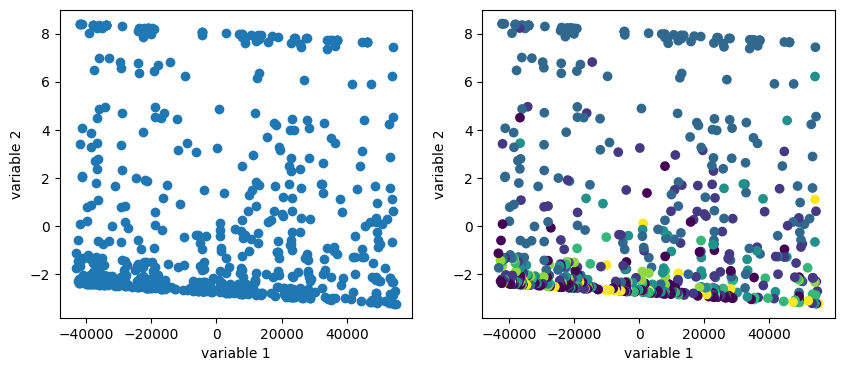

In [110]:
pca = PCA(n_components=2)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pc = pd.DataFrame(pca.transform(X))

# PCA does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_pc.iloc[:, 0], y=X_pc.iloc[:, 1], c=final_df3['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [111]:
kmeans = KMeans(n_clusters=len(final_df4['Label'].unique()), random_state=0, init='k-means++').fit(X_pc)
kmeans_results = kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_pc, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_pc, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_pc, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df4['Label'] , kmeans_results)}")

Silhouette Score: 0.6409672367235585
Calinski Harabasz Score: 6917.358740465887
Davies Bouldin Score: 0.41085308726617303
Adjusted Rand Index: 0.002315601522591607


### t-SNE

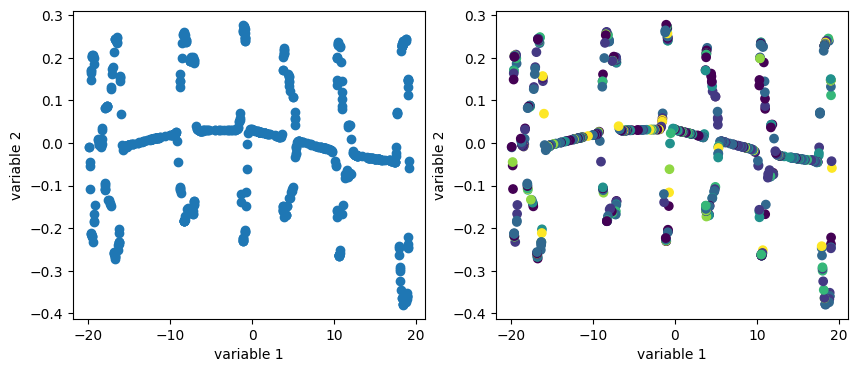

In [52]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=90).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [53]:
kmeans = KMeans(n_clusters=len(final_df4['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df4['Label'] , kmeans_results)}")

Silhouette Score: 0.6004916297578503
Calinski Harabasz Score: 5047.366816599581
Davies Bouldin Score: 0.46442457792582503
Adjusted Rand Index: 0.003609582849002205


#### User-based Clustering, frequent itemset contains at least 3 items

In [54]:
limit = np.percentile(item_count['count'], 99.9)

# We define frequent item as those that occur more than the average occurence
frequent_items = list(item_count[item_count['count']>limit]['itemsets'])
print(len(frequent_items))

new_col = []
for i in range(len(frequent_items)):
    if(len(frequent_items[i])>2):
        new_col.append(frequent_items[i])

new_df = pd.DataFrame(index=sparse_store_data.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data.index:
        for item in itemset:
            if sparse_store_data.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

# Adding Label to the new table with frequent items as features
final_df5 = new_df.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
"""
Combining label if multiple labels are found for the same Postal Code
eg: Postal 123 contains different transactions(rows) with different 'Segment' --> consumer and corporate, 
    it will be combined to one row with 'Segment' --> consumer, corporate
"""
final_df5 = final_df5.groupby('Postal Code').agg({
    **{col: 'max' for col in final_df5.columns if col not in ['Postal Code', 'Segment']},
    'Segment': lambda x: ', '.join(sorted(set(x)))
}).reset_index()
final_df5.rename(columns={"Segment": "Label"}, inplace=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df5['Label'] = le.fit_transform(final_df5['Label'])

# final_df.to_csv("../Result/SuperStoreFrequentFeatures1.csv")
print(final_df5.shape)
final_df5.head()

131


100%|██████████| 77/77 [00:36<00:00,  2.13it/s]

(631, 79)


,Postal Code,"(Art, Binders, Accessories)","(Art, Furnishings, Accessories)","(Art, Accessories, Paper)","(Art, Phones, Accessories)","(Art, Storage, Accessories)","(Chairs, Binders, Accessories)","(Binders, Furnishings, Accessories)","(Binders, Accessories, Paper)","(Phones, Binders, Accessories)",...,"(Storage, Binders, Art, Paper)","(Storage, Phones, Binders, Art)","(Phones, Furnishings, Art, Paper)","(Chairs, Binders, Furnishings, Paper)","(Phones, Binders, Furnishings, Paper)","(Storage, Binders, Furnishings, Paper)","(Storage, Phones, Binders, Furnishings)","(Storage, Phones, Binders, Paper)","(Phones, Storage, Furnishings, Paper)",Label
0,1040,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,1453,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1752,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1810,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1841,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,2


In [55]:
X = final_df5.iloc[:, :-1]
X= X.rename(str,axis="columns") 
kmeans = KMeans(n_clusters=len(final_df5['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df5['Label'] , kmeans_results)}")

Silhouette Score: 0.6409669784999028
Calinski Harabasz Score: 6917.358387284387
Davies Bouldin Score: 0.4108526792979873
Adjusted Rand Index: 0.002315601522591607


#### t-SNE

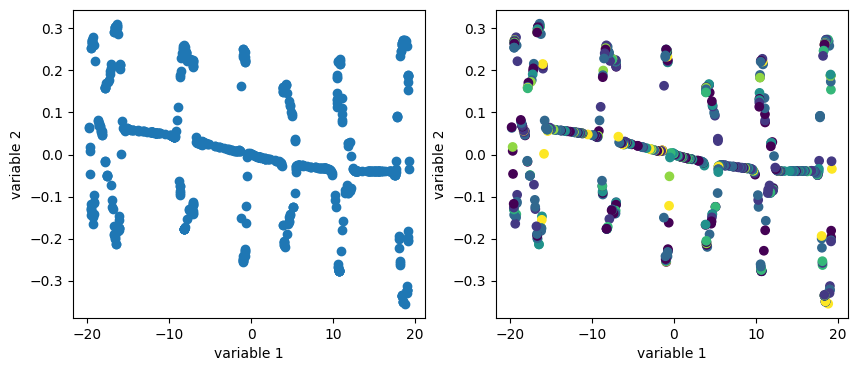

In [56]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=90).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [57]:
kmeans = KMeans(n_clusters=len(final_df4['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df4['Label'] , kmeans_results)}")

Silhouette Score: 0.5997978940026593
Calinski Harabasz Score: 5038.425780450546
Davies Bouldin Score: 0.4657658967592141
Adjusted Rand Index: 0.003088487224060686


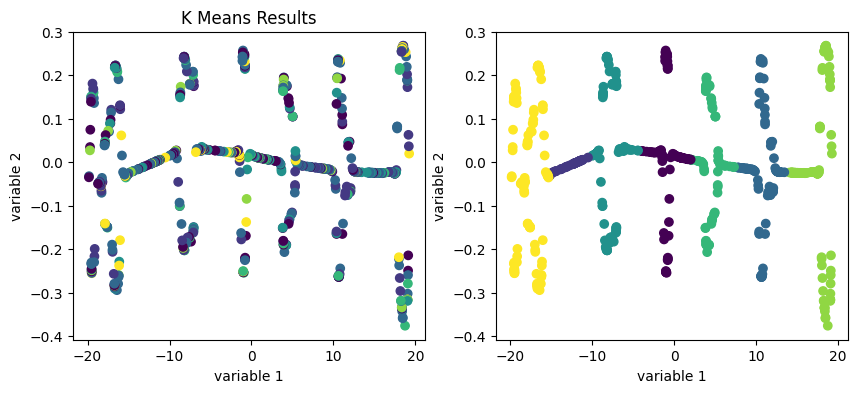

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[0].set_title("Ground Truth")
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[0].set_title("K Means Results")
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

#### User-based Clustering, frequent itemset contains at least 4 items

In [115]:
limit = np.percentile(item_count['count'], 99.9)

# We define frequent item as those that occur more than the average occurence
frequent_items = list(item_count[item_count['count']>limit]['itemsets'])
print(len(frequent_items))

new_col = []
for i in range(len(frequent_items)):
    if(len(frequent_items[i])>3):
        new_col.append(frequent_items[i])

new_df = pd.DataFrame(index=sparse_store_data.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data.index:
        for item in itemset:
            if sparse_store_data.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

# Adding Label to the new table with frequent items as features
final_df6 = new_df.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
"""
Combining label if multiple labels are found for the same Postal Code
eg: Postal 123 contains different transactions(rows) with different 'Segment' --> consumer and corporate, 
    it will be combined to one row with 'Segment' --> consumer, corporate
"""
final_df6 = final_df6.groupby('Postal Code').agg({
    **{col: 'max' for col in final_df6.columns if col not in ['Postal Code', 'Segment']},
    'Segment': lambda x: ', '.join(sorted(set(x)))
}).reset_index()
final_df6.rename(columns={"Segment": "Label"}, inplace=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df6['Label'] = le.fit_transform(final_df6['Label'])

# final_df.to_csv("../Result/SuperStoreFrequentFeatures1.csv")
print(final_df6.shape)
final_df6.head()

131


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:10<00:00,  2.05it/s]

(631, 23)


,Postal Code,"(Art, Binders, Furnishings, Accessories)","(Art, Binders, Accessories, Paper)","(Binders, Furnishings, Accessories, Paper)","(Phones, Binders, Furnishings, Accessories)","(Storage, Binders, Furnishings, Accessories)","(Phones, Binders, Accessories, Paper)","(Storage, Binders, Accessories, Paper)","(Storage, Phones, Binders, Accessories)","(Binders, Furnishings, Art, Paper)",...,"(Storage, Binders, Art, Paper)","(Storage, Phones, Binders, Art)","(Phones, Furnishings, Art, Paper)","(Chairs, Binders, Furnishings, Paper)","(Phones, Binders, Furnishings, Paper)","(Storage, Binders, Furnishings, Paper)","(Storage, Phones, Binders, Furnishings)","(Storage, Phones, Binders, Paper)","(Phones, Storage, Furnishings, Paper)",Label
0,1040,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,1453,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1752,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1810,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1841,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,2


In [117]:
X = final_df6.iloc[:, :-1]
X= X.rename(str,axis="columns") 
kmeans = KMeans(n_clusters=len(final_df6['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df6['Label'] , kmeans_results)}")

Silhouette Score: 0.6409683311750412
Calinski Harabasz Score: 6917.363889524644
Davies Bouldin Score: 0.41085052645960307
Adjusted Rand Index: 0.002315601522591607


#### r-SNE

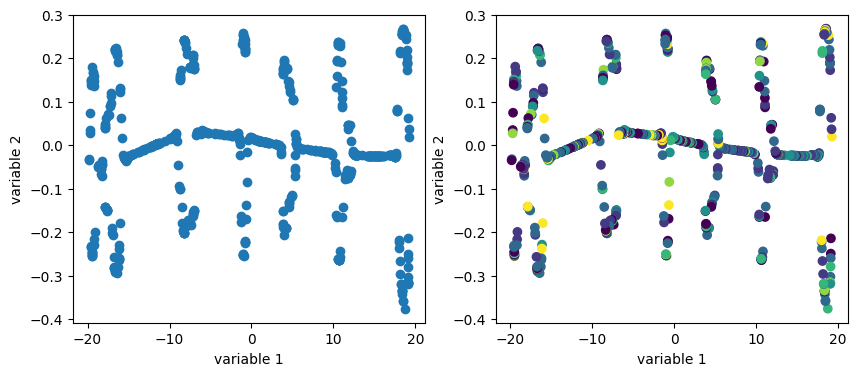

In [118]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=90).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df6['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [120]:
kmeans = KMeans(n_clusters=len(final_df6['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, kmeans_results)}")
print(f"Adjusted Rand IndeX_embedded: {adjusted_rand_score(final_df6['Label'] , kmeans_results)}")

Silhouette Score: 0.6418704390525818
Calinski Harabasz Score: 7756.4807603042045
Davies Bouldin Score: 0.4439005404203679
Adjusted Rand IndeX_embedded: 0.003609582849002205
